# **発電量のデータを分析する**

### **必要な関数・モジュール**

In [1]:
# データ加工・処理・分析モジュール
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import random

%matplotlib inline

import time

In [2]:
def set_time(dataframe, col_name):
    '''
    to_datetimeを使うための前処理
    '''
    dataframe[col_name] = dataframe[col_name].map(lambda x : transform_time(x))
    return dataframe

In [3]:
def transform_time(x):
    '''
    set_time内で使う関数
    to_datetimeで24時をサポートしないので00に変更する処理
    '''
    str_x = str(x)
    res = ''
    if str(x)[8:10] == '24':
        res = str_x[0:4] + '-' + str_x[4:6] + '-' + str_x[6:8] + ' 00:'+str_x[10:12] 
    else:
        res = str_x[0:4] + '-' + str_x[4:6] + '-' + str_x[6:8] + ' '+ str_x[8:10] +':'+str_x[10:12]
    return res

In [4]:
def get_hours(x):
    '''
    時間帯毎に分類するための関数
    '''
    num = 0
    num += int(x.hour) * 2
    if int(x.minute) == 30:
        num += 1
    return num

In [5]:
def add_times(df):
    '''
    datetimeカラムがあることを前提に年, 月, 時カラムを足す
    '''
    df['hours'] = df['datetime'].map(lambda x: get_hours(x))
    df['month'] = df['datetime'].map(lambda x: x.month)
    df['year'] = df['datetime'].map(lambda x: x.year)
    return df

In [6]:
def denormalize_array(normalized_x, x_min, x_max):
    '''
    正規化前のmin, maxを用いて元のスケールに戻す
    '''
    normalized_x = np.array(normalized_x)
    denormalize_array = (normalized_x) * (x_max - x_min) + x_min
    return denormalize_array

In [7]:
def get_input_data(X):
    '''
    全時系列データから00:00 ~ 20:00までのデータごとに分割する
    '''
    input_list = []
    # 一日は48個の時間帯に分けられる
    total_size = len(X) // 48
    reshaped_size = X[0:41].shape[0] * X[0:41].shape[1]
    for i in range(total_size+1):
        each_data = X[(i*48):(i*48+41)]
        reshaped = each_data.reshape(reshaped_size)
        input_list.append(list(reshaped))
    input_list = np.array(input_list)
    return input_list

In [8]:
def get_output_data(Y):
    '''
    全時系列データから00:00 ~ 23:30までのデータごとに分割する
    '''
    output_list = []
    # 一日は48個の時間帯に分けられる
    total_size = len(Y) // 48
    for i in range(total_size):
        each_data = Y[(i*48):(i*48+48)]
        reshaped = each_data.reshape(48)
        output_list.append(list(reshaped))
    output_list = np.array(output_list)
    return output_list

In [9]:
def drop_nan(X, Y):
    '''
    Yにnanが含まれるペアを削除(他のとこにあるdrop_nanとは別物なので注意)
    '''
    mask = []
    for i in range(len(Y)):
        if np.isnan(Y[i]).sum() == 0:
            mask.append(True)
        else:
            mask.append(False)
    X = X[mask]
    Y = Y[mask]
    return X, Y

In [10]:
def calc_mae(X, Y):
    '''
    X, Yがメモリを食いすぎるのでfor文で計算
    '''
    mse = 0
    for i in range(len(X)):
        mse += np.abs(X[i]- Y[i])
    return mse/len(X)

### **データを読み込む**

In [11]:
target_place = 1

In [12]:
# 発電量データ
output_30 = pd.read_csv('data/processed_data/out_put.tsv', delimiter = '\t')
output_30['datetime'] = output_30['datetime'].map(lambda x : pd.to_datetime(x))

In [13]:
# 予測データ
predict_30 = pd.read_csv('data/predicted_data/predict_SOLA01.tsv', delimiter = '\t')
predict_30['datetime'] = predict_30['datetime'].map(lambda x : pd.to_datetime(x))
predict_30 = predict_30[['datetime', 'predict_SOLA0'+str(target_place)]]
predict_30.columns = [['datetime', 'prediction']]

### **分析スタート**

In [14]:
output_30 = output_30[['datetime', 'SOLA0'+str(target_place)]]
output_30.columns = [['datetime', 'actual']]

In [15]:
output_30 = add_times(output_30)

In [16]:
predict_30 = add_times(predict_30)

In [17]:
hours_output = output_30.groupby(['hours'], as_index=False).mean()
hours_predict = predict_30.groupby(['hours'], as_index=False).mean()

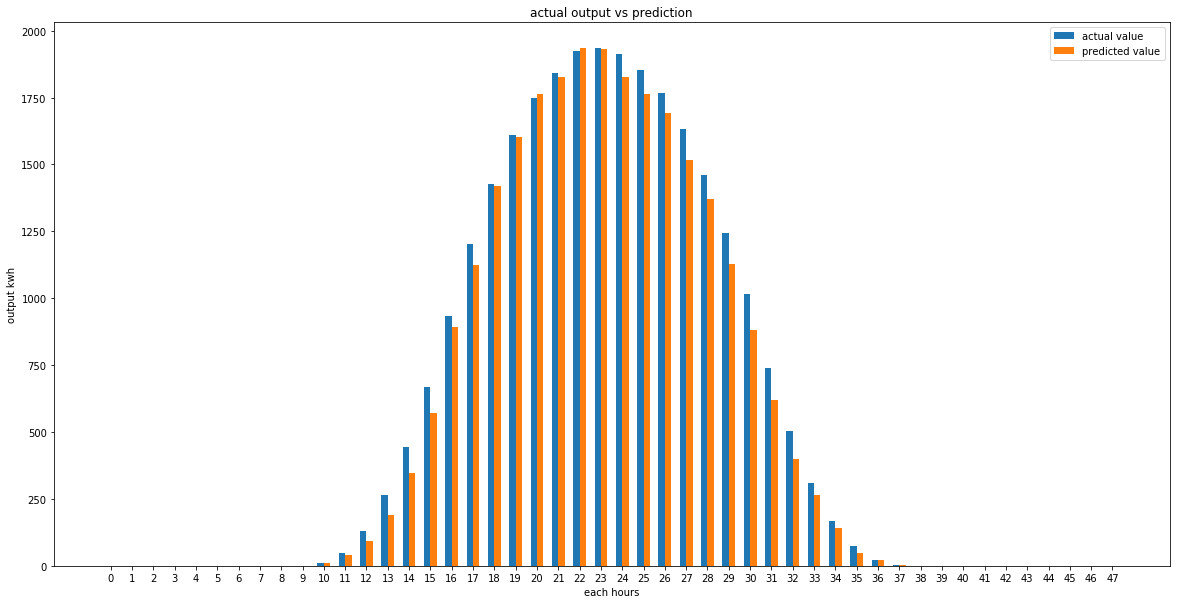

In [18]:
left_1 = np.array(hours_output['hours']) - 0.15
height_1 = np.array(hours_output['actual'])
left_2 = np.array(hours_predict['hours']) + 0.15
height_2 = np.array(hours_predict['prediction'])
plt.figure(figsize=(20, 10))
plt.bar(left_1, height_1, width=0.3, label = "actual value", align="center")
plt.bar(left_2, height_2, width=0.3, label = "predicted value", align="center")
plt.title("actual output vs prediction")
plt.legend()
plt.xticks(left_1+0.15, np.array(hours_output['hours']))
plt.xlabel("each hours")
plt.ylabel("output kwh")

** 0:00 ~ 4:00, 19:00 ~ 23:30の間は4年間一度も発電してない(当たり前) ** 

** この時間帯は予測の対象から外してもいいかも?(スコアは数ポイントしか改善しなさそう)**

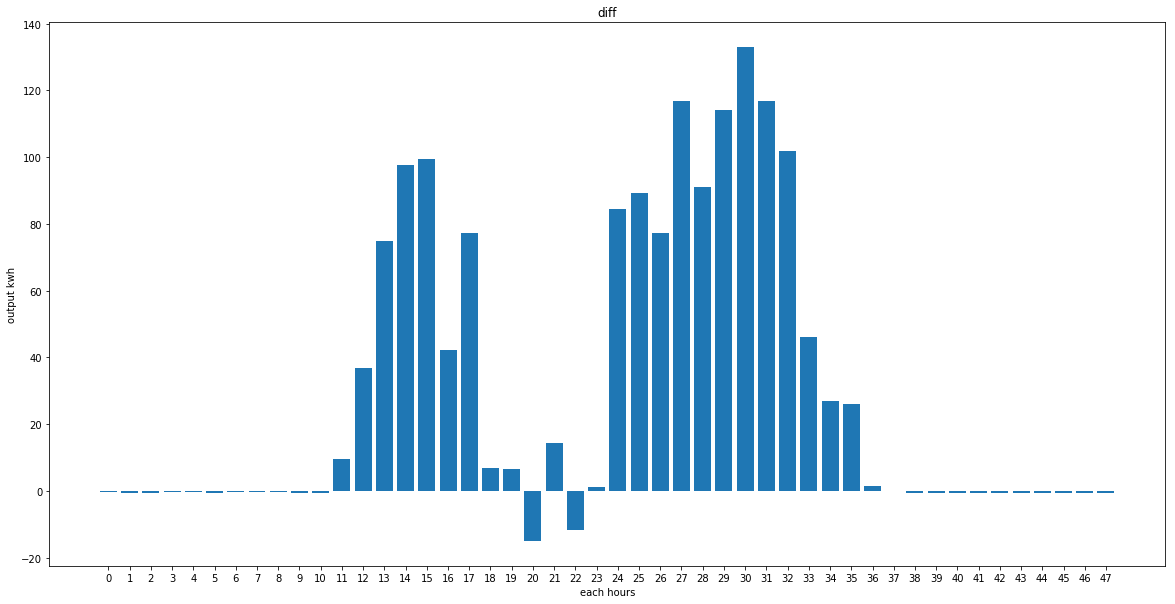

In [19]:
left = np.array(hours_output['hours'])
height = np.array(hours_output['actual']) - np.array(hours_predict['prediction'])
plt.figure(figsize=(20, 10))
plt.bar(left, height, width=0.8, align="center")
plt.title("diff")
plt.xticks(left, np.array(hours_output['hours']))
plt.xlabel("each hours")
plt.ylabel("output kwh")

### **ピーク時の発電量の予測は意外とうまくいってる**

### **発電量自体の分析**

In [20]:
ymh_output = output_30.groupby(['year', 'month', 'hours'], as_index=False).mean()

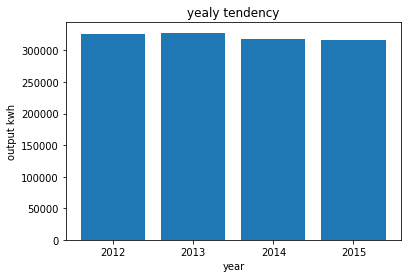

In [21]:
tmp = ymh_output.groupby(['year'], as_index = False).sum()
left = np.array(tmp['year'])
height = np.array(tmp['actual'])
# plt.figure(figsize=(20, 10))
plt.bar(left, height, tick_label = [2012, 2013, 2014, 2015], width=0.8)
plt.title("yealy tendency")
plt.xlabel("year")
plt.ylabel("output kwh")

In [22]:
monthly_output = output_30.groupby(['month'], as_index=False).sum()

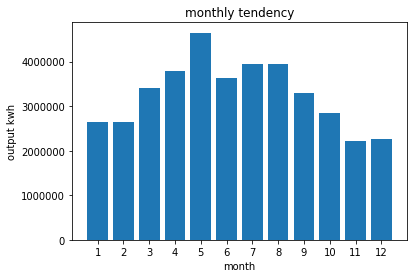

In [23]:
plt.bar(monthly_output['month'], monthly_output['actual'], tick_label=np.arange(12)+1, width = 0.8)
plt.xlabel("month")
plt.ylabel("output kwh")
plt.title("monthly tendency")

In [24]:
ym_output = output_30.groupby(['year', 'month'], as_index=False).sum()

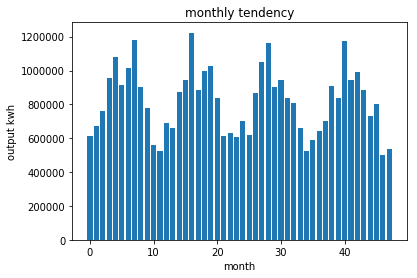

In [25]:
plt.bar(np.arange(len(ym_output)), ym_output['actual'], width = 0.8)
plt.xlabel("month")
plt.ylabel("output kwh")
plt.title("monthly tendency")

### **予測値との比較**